In [ ]:
#connect to google drive
#not necessary if you are running script locally
%load_ext autoreload
%autoreload 2
from google.colab import drive
drive.mount('/content/drive')

import os
import sys
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'luyan'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))
sys.path.append(GOOGLE_DRIVE_PATH)

Mounted at /content/drive
['车辆数据.xlsx', '车型数据.xlsx', '地址库信息(配送地址).xlsx', '地点线路表.numbers', 'general_notes.docx', 'new_onlyXiamen_addcode.csv', 'products_new.csv', '__MACOSX', '鹭燕-物流各流程基础数据-8.30', 'route_planner', 'data', 'luyan_week5_da.ipynb', 'cleaned_data', 'my_add_data.csv', 'my_add_data.gsheet', 'Week6&7.ipynb', '__pycache__', 'week8.ipynb', 'utils.py', 'week10.ipynb', 'week12.ipynb']


## Import Packages

In [ ]:
!pip install pyvrp
import pyvrp
from pyvrp import Model, read
from pyvrp.plotting import (
    plot_coordinates,
    plot_instance,
    plot_result,
    plot_route_schedule,
    plot_solution
)
from pyvrp.stop import NoImprovement

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from scipy.special import inv_boxcox

#local helpers
sys.path.append(GOOGLE_DRIVE_PATH + '/utils.py')  # Replace with the actual path to your utils.py file
from utils import clean_tms
from utils import get_agg_by_date
from utils import get_agg_by_rand
from utils import get_dist_time_mat


## Build Regression Model for real travel time

### Data Cleaning and Transformation

In [ ]:
real_df = pd.read_csv(GOOGLE_DRIVE_PATH + '/cleaned_data/9.1-停车点200mlocations_dis4w_dur1w.csv')
X = np.array(real_df[['distance', 'duration']])
y = np.array(real_df[['distance_r', 'duration_r']])

In [ ]:
print(real_df.shape)
real_df.head()

(155, 10)


,origin,destination,origin_location,destination_location,distance,duration,distance_r,duration_r,distance_ratio,duration_ratio
0,1523453,762,"118.136807,24.480001","118.155633,24.48001",2711,658,2990,871,1.102914,1.323708
1,762,754,"118.155633,24.48001","118.164853,24.475351",2176,472,2450,689,1.125919,1.459746
2,754,761,"118.164853,24.475351","118.166637,24.476225",1726,504,280,60,0.162225,0.119048
3,761,1101,"118.166637,24.476225","118.167494,24.471628",1811,466,700,210,0.386527,0.450644
4,1101,2229990,"118.167494,24.471628","118.173857,24.481457",2174,490,2090,1207,0.961362,2.463265


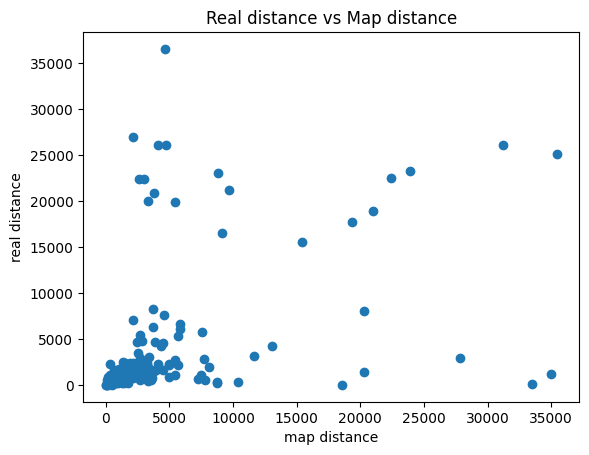

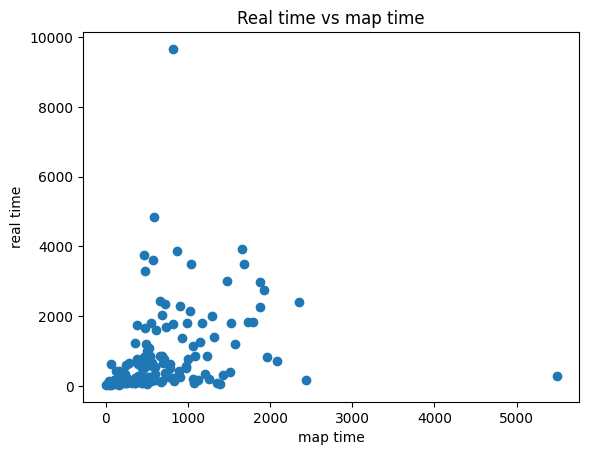

In [ ]:
plt.scatter(X[:, 0], y[:, 0])
plt.xlabel('map distance')
plt.ylabel('real distance')
plt.title('Real distance vs Map distance')
plt.show()

plt.scatter(X[:, 1], y[:, 1])
plt.xlabel('map time')
plt.ylabel('real time')
plt.title('Real time vs map time')
plt.show()

In [ ]:
#remove outliters
def remove_outlier(data, index):
  x = data.iloc[:, index]
  q1 = np.percentile(x, 25)
  q3 = np.percentile(x, 75)
  iqr = q3 - q1
  upper_bound = q3 + 1.5*iqr
  new_data = data[data.iloc[:, index] < upper_bound]

  return new_data

clean_df = remove_outlier(real_df, 4)
clean_df = remove_outlier(clean_df, 5)
clean_df = remove_outlier(clean_df, 6)
clean_df = remove_outlier(clean_df, 7)
print(clean_df.shape)

X = np.array(clean_df[['distance', 'duration']])
y = np.array(clean_df[['distance_r', 'duration_r']])

(109, 10)


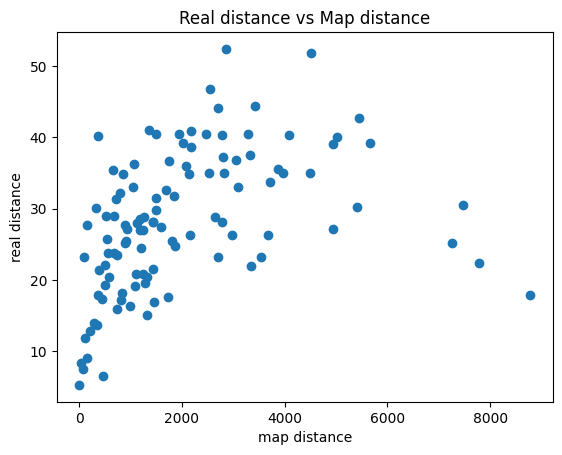

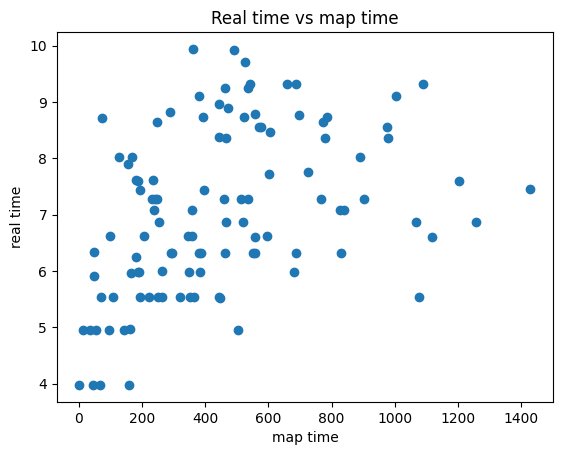

In [ ]:
#boxcox transormation to resolve non-equal variance
y0_trans, lambda_value_0 = stats.boxcox(y[:, 0])
y1_trans, lambda_value_1 = stats.boxcox(y[:, 1])
y_trans = np.concatenate((y0_trans.reshape(-1, 1), y1_trans.reshape(-1, 1)), axis=1)

plt.scatter(X[:, 0], y0_trans)
plt.xlabel('map distance')
plt.ylabel('real distance')
plt.title('Real distance vs Map distance')
plt.show()

plt.scatter(X[:, 1], y1_trans)
plt.xlabel('map time')
plt.ylabel('real time')
plt.title('Real time vs map time')
plt.show()

### Linear Regression

#### Regress on distance

In [ ]:
dist_model = LinearRegression()
dist_model.fit(X, y_trans[:, 0])
X_inter = sm.add_constant(X)
dist_model_sm = sm.OLS(y_trans[:, 0], X_inter).fit()

#test statistics
y_pred = dist_model.predict(X)
mse = mean_squared_error(y_trans[:, 0], y_pred)
r2 = r2_score(y_trans[:, 0], y_pred)
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'R-squared (R2): {r2:.2f}')

Mean Squared Error (MSE): 75.63
R-squared (R2): 0.21


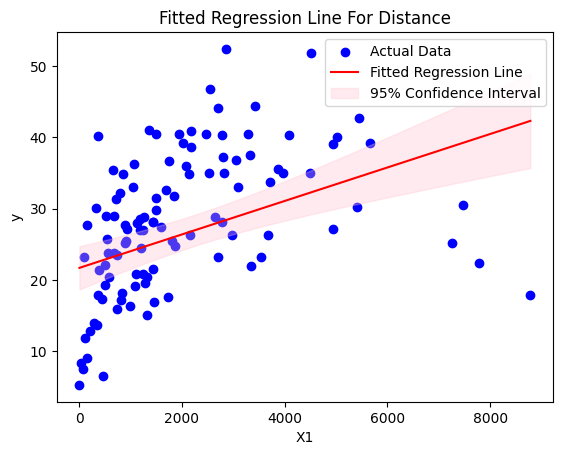

In [ ]:
x_line = np.concatenate((np.linspace(min(X[:, 0]), max(X[:, 0]), 100).reshape(-1, 1),
                        np.linspace(min(X[:, 1]), max(X[:, 1]), 100).reshape(-1, 1)), axis = 1)
x_line_int = sm.add_constant(x_line)
y_line = dist_model_sm.predict(x_line_int)
predictions = dist_model_sm.get_prediction(x_line_int)
ci = predictions.conf_int()

plt.scatter(X[:, 0], y_trans[:, 0], label='Actual Data', color='blue')
plt.plot(x_line[:, 0], y_line, label='Fitted Regression Line', color='red')
plt.fill_between(x_line[:, 0], ci[:, 0], ci[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.xlabel('X1')
plt.ylabel('y')
plt.title('Fitted Regression Line For Distance')
plt.legend()
plt.show()

#### Regress on time

In [ ]:
time_model = LinearRegression()
time_model.fit(X, y_trans[:, 1])
X_inter = sm.add_constant(X)
time_model_sm = sm.OLS(y_trans[:, 1], X_inter).fit()

#test statistics
y_pred = time_model.predict(X)
mse = mean_squared_error(y_trans[:, 1], y_pred)
r2 = r2_score(y_trans[:, 1], y_pred)
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'R-squared (R2): {r2:.2f}')

Mean Squared Error (MSE): 1.75
R-squared (R2): 0.17


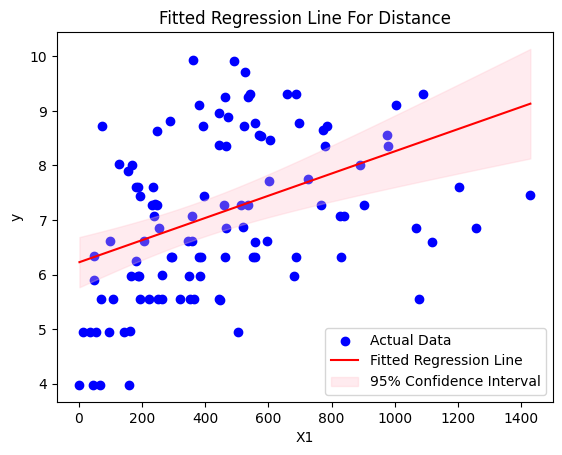

In [ ]:
x_line = np.concatenate((np.linspace(min(X[:, 0]), max(X[:, 0]), 100).reshape(-1, 1),
                        np.linspace(min(X[:, 1]), max(X[:, 1]), 100).reshape(-1, 1)), axis = 1)
x_line_int = sm.add_constant(x_line)
y_line = time_model_sm.predict(x_line_int)
predictions = time_model_sm.get_prediction(x_line_int)
ci = predictions.conf_int()

plt.scatter(X[:, 1], y_trans[:, 1], label='Actual Data', color='blue')
plt.plot(x_line[:, 1], y_line, label='Fitted Regression Line', color='red')
plt.fill_between(x_line[:, 1], ci[:, 0], ci[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.xlabel('X1')
plt.ylabel('y')
plt.title('Fitted Regression Line For Distance')
plt.legend()
plt.show()

### Build Simulator

In [ ]:
def sec_to_min(s):
  return round(s/60)

#read res
def get_real_time(time_mat, dist_mat, res):
  total_real = 0
  total_map = 0
  routes = res.best.get_routes()
  for route in routes:
    spots = route.visits()
    X = np.zeros((len(spots) + 1, 2))
    X[0, 0] = dist_mat[0, spots[0]]
    X[0, 1] = time_mat[0, spots[0]]
    map_time = [time_mat[0, spots[0]]]
    map_dist = [dist_mat[0, spots[0]]]
    for i in range(len(spots) - 1):
      X[i, 0] = dist_mat[spots[i], spots[i + 1]]
      X[i, 1] = time_mat[spots[i], spots[i + 1]]
      map_time.append(time_mat[spots[i], spots[i + 1]])
      map_dist.append(dist_mat[spots[i], spots[i + 1]])

    time_pred = inv_boxcox(time_model.predict(X), lambda_value_1)
    dist_pred = inv_boxcox(dist_model.predict(X), lambda_value_0)
    print(f"route {i}: {route}")
    print(f"Predicted real time: {sec_to_min(sum(time_pred))} minutes, Map time: {sec_to_min(sum(X[:, 1]))} minutes")
    print(f"Predicted real distance: {round(sum(dist_pred))} m, Map time: {round(sum(X[:, 0]))} m\n")
    total_real += sec_to_min(sum(time_pred))
    total_map += sec_to_min(sum(X[:, 1]))
  print(f"Total Predicted real time: {total_real} minutes,  Totoal Map time: {total_map} minutes")

## Prepare training data and distance matrix

In [ ]:
#read data in
add_df = pd.read_excel(GOOGLE_DRIVE_PATH + '/地址库信息(配送地址).xlsx')
load_df = pd.read_csv(GOOGLE_DRIVE_PATH + '/鹭燕-物流各流程基础数据-8.30/TMS派车运单/TMS派车装载管理820001.csv')
traffic_df = pd.read_csv(GOOGLE_DRIVE_PATH + '/cleaned_data/trip_details_2023-07-21_Xiamen_20231020_1126.csv')
craw_df = pd.read_csv(GOOGLE_DRIVE_PATH + '/cleaned_data/2023-07-21_Xiamen.csv')

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
<ipython-input-79-d9dcba223ae5>:3: DtypeWarning: Columns (30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  load_df = pd.read_csv(GOOGLE_DRIVE_PATH + '/鹭燕-物流各流程基础数据-8.30/TMS派车运单/TMS派车装载管理820001.csv')


In [ ]:
def get_agg_by_rand(size, tms_df, add_df, craw_df):
  #format add_df
  add_df['TRANSID'] = add_df['地址名称'].str.extract(r'\((\d+)\)')
  add_df['TRANSID'] = add_df['TRANSID'].astype(int)

  #randomly draw samples of given size
  tid_set = set(craw_df['TRANSID'].unique())
  tms_valid = tms_df[tms_df['TRANSID'].isin(tid_set)]
  tms_rand = tms_valid.sample(n=size, replace=False)

  #aggregate and fill in latitude/longitude
  rand_agg = tms_rand.groupby(['TRANSID', 'URGENTFLAG'], as_index=False).agg({'VOLUME': 'sum', 'WEIGHT': 'sum',
                                                                              'ROUTEID': 'first', 'LONGITUDE': 'first', 'LATITUDE': 'first', 'ADDRESS': 'first',
                                                                              'SOURCEID': ', '.join})
  rand_agg_full = pd.merge(rand_agg[['TRANSID', 'URGENTFLAG', 'VOLUME', 'WEIGHT', 'ROUTEID', 'SOURCEID']],
                    add_df[['TRANSID', '经度', '纬度', '地址']],
                    on = 'TRANSID')
  rand_agg_full.columns = ['TRANSID', 'URGENTFLAG', 'VOLUME', 'WEIGHT', 'ROUTEID', 'SOURCEID', 'LATITUDE', 'LONGITUDE', 'ADDRESS']

  #drop na values
  pre_shape = rand_agg_full.shape
  rand_agg_full = rand_agg_full[rand_agg_full['LATITUDE'].notna()]
  cur_shape = rand_agg_full.shape
  print("Dropped {} longitude/latitude missing values, now {} rows left with original size {}.".format(pre_shape[0] - cur_shape[0], cur_shape[0], size))

  #add dummy line at top for df
  #new_row = pd.Series({'TRANSID': 0, 'URGENRFLAG': 0, 'VOLUME': 0, 'WEIGHT': 0, 'ROUTEID': 0, 'LONGUTUDE': 0, 'LATITUDE': 0, 'ADDRESS': "", 'SOURCEID': 0})
  #rand_agg = pd.concat([new_row.to_frame().T, rand_agg], ignore_index=True)

  return rand_agg

In [ ]:
def get_dist_time_mat(agg_df, craw_df, traffic_df):
  n = max(traffic_df['origin'].max(), traffic_df['destination'].max())
  distance_mat = np.zeros((n+1, n+1))
  time_mat = np.zeros((n+1, n+1))

  for i in range(traffic_df.shape[0]):
    origin = traffic_df.iloc[i, 2]
    destination = traffic_df.iloc[i, 3]
    distance_mat[origin, destination] = traffic_df.iloc[i, 0]
    distance_mat[destination, origin] = traffic_df.iloc[i, 0]
    if (traffic_df.iloc[i, 1] > 0):
      time_mat[origin, destination] = traffic_df.iloc[i, 1]
      time_mat[destination, origin] = traffic_df.iloc[i, 1]
    else:
      print("warning: invalid time value at index {}, replaced with mean time {}".format(i, int(traffic_df['duration'].mean())))
      time_mat[origin, destination] = int(traffic_df['duration'].mean())

  #fill na blocks with very large values bacause we want to avoid these routes
  miss_dist = 0
  miss_time = 0
  max_dist = distance_mat.max()
  max_time = time_mat.max()
  for i in range(n + 1):
    for j in range(n + 1):
      if (distance_mat[i, j] == 0 and i != j):
        distance_mat[i, j] = max_dist*10
        miss_dist = miss_dist + 1
      if (time_mat[i, j] == 0 and i != j):
        time_mat[i, j] = max_time*10
        miss_time = miss_time + 1
  print("Filled up {} missing distance entries and {} missing time entries with 10*max".format(miss_dist, miss_time))

  #get index order list by tids
  #rearrange distmat based on one_day_add_full
  order_index = [0]
  remain_tids = [0]
  for i in range(agg_df.shape[0]):
    tid = agg_df.iloc[i, 0]
    res = craw_df.loc[craw_df['TRANSID'] == tid]
    if (res.shape[0] == 1):
      order_index.append(res.index[0])
      remain_tids.append(tid)
  print("{} (merged) order remaining.".format(len(order_index)))

  small_dist = distance_mat[:, order_index][order_index, :]
  small_time = time_mat[:, order_index][order_index, :]

  return small_dist, small_time

In [ ]:
#clean tms
res = clean_tms(load_df)
tms_df = res[0]
del_sid = res[1]

rand_agg = get_agg_by_rand(200, tms_df, add_df, craw_df)
rand_agg_200 = rand_agg.dropna()

rand_agg = get_agg_by_rand(100, tms_df, add_df, craw_df)
rand_agg_100 = rand_agg.dropna()

rand_agg = get_agg_by_rand(30, tms_df, add_df, craw_df)
rand_agg_30 = rand_agg.dropna()


#calculate distance matrix and time matrix for agg data
res = get_dist_time_mat(rand_agg_200, craw_df, traffic_df)
dist_mat_200 = res[0]
time_mat_200 = res[1]

res = get_dist_time_mat(rand_agg_100, craw_df, traffic_df)
dist_mat_100 = res[0]
time_mat_100 = res[1]

res = get_dist_time_mat(rand_agg_30, craw_df, traffic_df)
dist_mat_30 = res[0]
time_mat_30 = res[1]

/content/drive/MyDrive/luyan/utils.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  load_df[columns_to_replace] =load_df[columns_to_replace].fillna(0)


Dropped 1 na values, now 71627 rows left
Dropped 9770 abnormal weight or colume values, now 61857 rows left
Current dataset has dates ranging from 2023-05-02T08:27:34.000000000 to 2023-08-29T17:06:38.000000000.
Dropped 0 longitude/latitude missing values, now 108 rows left with original size 200.
Dropped 0 longitude/latitude missing values, now 74 rows left with original size 100.
Dropped 0 longitude/latitude missing values, now 28 rows left with original size 30.
Filled up 0 missing distance entries and 0 missing time entries with 10*max
72 (merged) order remaining.
Filled up 0 missing distance entries and 0 missing time entries with 10*max
44 (merged) order remaining.
Filled up 0 missing distance entries and 0 missing time entries with 10*max
18 (merged) order remaining.


In [ ]:
#read vehicle data
veh = pd.read_csv(GOOGLE_DRIVE_PATH + "/cleaned_data/车辆额定信息.csv").iloc[:,1:]
veh.columns = ["plate", "weight", "size"]
veh.weight = veh.weight.astype(int)

## PyVRP

###1. Small Toy Example
30 orders, 18 clients, weight constraint

In [ ]:
m_30 = Model()
for i in range(len(veh)):
    m_30.add_vehicle_type(capacity=veh.weight[i], num_available=1)
depot = m_30.add_depot(x = 1180073, y = 245989)
clients = [
    m_30.add_client(x = int(rand_agg_30.iloc[idx, 5]*10000),
                 y = int(rand_agg_30.iloc[idx, 6]*10000),
                 demand = int(rand_agg_30.iloc[idx, 3])) #constrained by weight
    for idx in range(len(rand_agg_30))
]
locations = [depot, *clients]

for i in range(len(locations)):
    for j in range(len(locations)):
        distance = dist_mat_30[i, j]
        duration = time_mat_30[i, j]
        m_30.add_edge(locations[i], locations[j], distance=distance)

In [ ]:
from pyvrp.stop import NoImprovement
res_30 = m_30.solve(stop = NoImprovement(max_iterations = 10000))

Solution results
    # routes: 2
   # clients: 17
   objective: 186995.00
# iterations: 13711
    run-time: 27.66 seconds

Routes
------
Route #1: 8 17 9 16 
Route #2: 11 10 4 5 3 13 12 2 7 15 14 6 1 

route 2: 8 17 9 16 
Predicted real time: 24 minutes, Map time: 36 minutes
Predicted real distance: 4851 m, Map time: 14476 m

route 11: 11 10 4 5 3 13 12 2 7 15 14 6 1 
Predicted real time: 178 minutes, Map time: 168 minutes
Predicted real distance: 21008 m, Map time: 96799 m

Total Predicted real time: 202 minutes,  Totoal Map time: 204 minutes


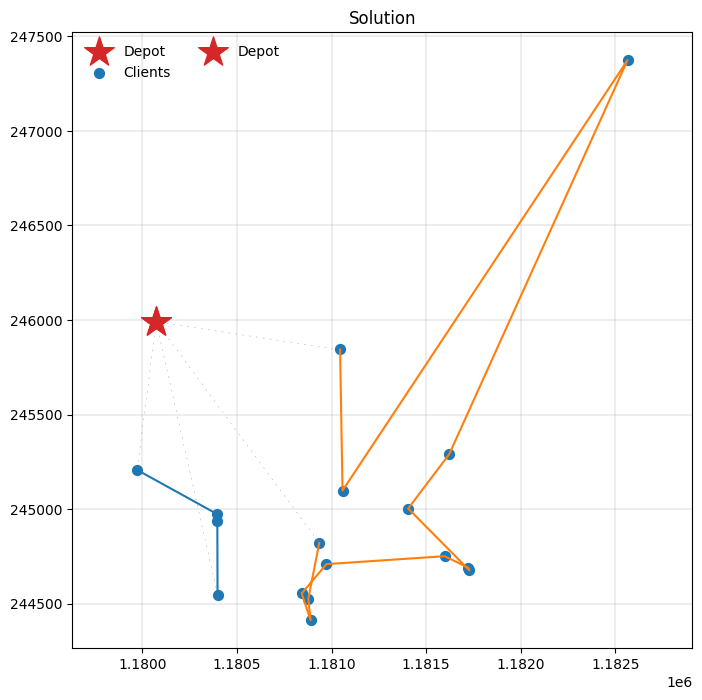

In [ ]:
print(res_30)
data_30 = m_30.data()
_, ax = plt.subplots(figsize=(8, 8))
plot_coordinates(data_30, ax=ax)
plot_solution(res_30.best, data_30, ax = ax)
get_real_time(time_mat_30, dist_mat_30, res_30)

#### Adding toy time_constraint

In [ ]:
m_30_time = Model()
for i in range(len(veh)):
    m_30_time.add_vehicle_type(capacity=veh.weight[i], num_available=1)
depot = m_30_time.add_depot(x = 1180073, y = 245989)
clients = [
    m_30_time.add_client(x = int(rand_agg_30.iloc[idx, 5]*10000),
                 y = int(rand_agg_30.iloc[idx, 6]*10000),
                 demand = int(rand_agg_30.iloc[idx, 3])) #constrained by weight
    for idx in range(len(rand_agg_30))
]
locations = [depot, *clients]

for i in range(len(locations)):
    for j in range(len(locations)):
        distance = dist_mat_30[i, j]
        duration = time_mat_30[i, j]
        m_30.add_edge(locations[i], locations[j], distance=distance, duration = duration)

In [ ]:
res_30_time = m_30_time.solve(stop = NoImprovement(max_iterations = 10000))

Solution results
    # routes: 5
   # clients: 17
   objective: -1073741824.00
# iterations: 10256
    run-time: 27.50 seconds

Routes
------
Route #1: 13 11 5 6 
Route #2: 10 
Route #3: 2 
Route #4: 4 17 
Route #5: 16 3 1 14 12 8 15 9 7 

route 2: 13 11 5 6 
Predicted real time: 90 minutes, Map time: 65 minutes
Predicted real distance: 8446 m, Map time: 43598 m

route 2: 10 
Predicted real time: 52 minutes, Map time: 31 minutes
Predicted real distance: 4151 m, Map time: 26030 m

route 2: 2 
Predicted real time: 59 minutes, Map time: 31 minutes
Predicted real distance: 4217 m, Map time: 28105 m

route 0: 4 17 
Predicted real time: 19 minutes, Map time: 20 minutes
Predicted real distance: 3040 m, Map time: 12347 m

route 7: 16 3 1 14 12 8 15 9 7 
Predicted real time: 346 minutes, Map time: 214 minutes
Predicted real distance: 26075 m, Map time: 178497 m

Total Predicted real time: 566 minutes,  Totoal Map time: 361 minutes


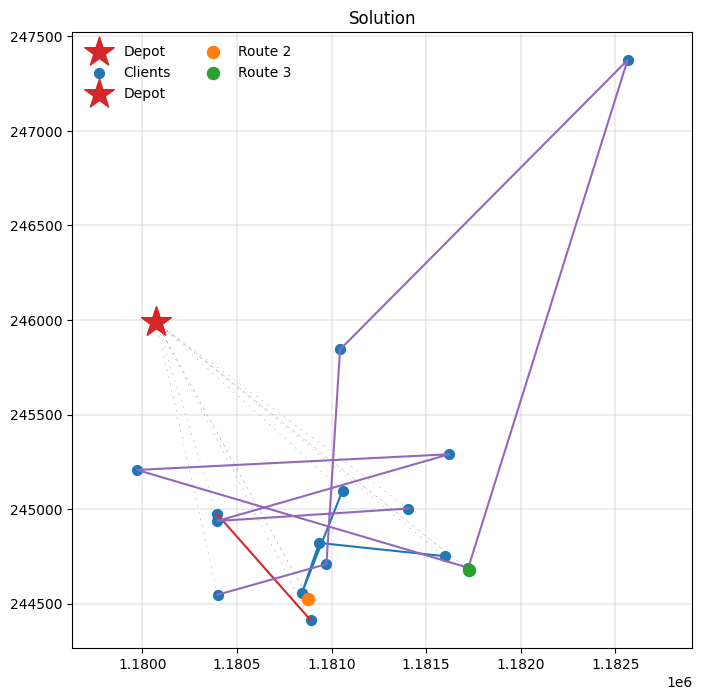

In [ ]:
print(res_30_time)
data_30_time = m_30_time.data()
_, ax = plt.subplots(figsize=(8, 8))
plot_coordinates(data_30_time, ax=ax)
plot_solution(res_30_time.best, data_30_time, ax = ax)
get_real_time(time_mat_30, dist_mat_30, res_30_time)

### Bigger Toy Example
100 orders,

In [ ]:
m_100 = Model()
for i in range(len(veh)):
    m_100.add_vehicle_type(capacity=veh.weight[i], num_available=1)
depot = m_100.add_depot(x = 1180073, y = 245989)
clients = [
    m_100.add_client(x = int(rand_agg_100.iloc[idx, 5]*10000),
                 y = int(rand_agg_100.iloc[idx, 6]*10000),
                 demand = int(rand_agg_100.iloc[idx, 3])) #constrained by weight
    for idx in range(len(rand_agg_100))
]
locations = [depot, *clients]

for i in range(len(locations)):
    for j in range(len(locations)):
        distance = dist_mat_100[i, j]
        duration = time_mat_100[i, j]
        m_100.add_edge(locations[i], locations[j], distance=distance)

In [ ]:
res_100 = m_100.solve(stop = NoImprovement(max_iterations = 10000))

### Even Bigger

In [ ]:
m_200 = Model()
for i in range(len(veh)):
    m_200.add_vehicle_type(capacity=veh.weight[i], num_available=1)
depot = m_200.add_depot(x = 1180073, y = 245989)
clients = [
    m_200.add_client(x = int(rand_agg_200.iloc[idx, 5]*10000),
                 y = int(rand_agg_200.iloc[idx, 6]*10000),
                 demand = int(rand_agg_200.iloc[idx, 3])) #constrained by weight
    for idx in range(len(rand_agg_200))
]
locations = [depot, *clients]

for i in range(len(locations)):
    for j in range(len(locations)):
        distance = dist_mat_200[i, j]
        duration = time_mat_200[i, j]
        m_100.add_edge(locations[i], locations[j], distance=distance)

In [ ]:
res_200 = m_100.solve(stop = NoImprovement(max_iterations = 10000))

#### Inspect Results

Solution results
    # routes: 2
   # clients: 42
   objective: 215766.00
# iterations: 10594
    run-time: 40.12 seconds

Routes
------
Route #1: 5 3 28 40 4 42 33 34 23 30 29 21 1 39 2 35 
Route #2: 15 16 10 27 12 13 17 20 14 22 11 36 19 32 6 7 8 25 24 9 38 26 31 41 18 37 



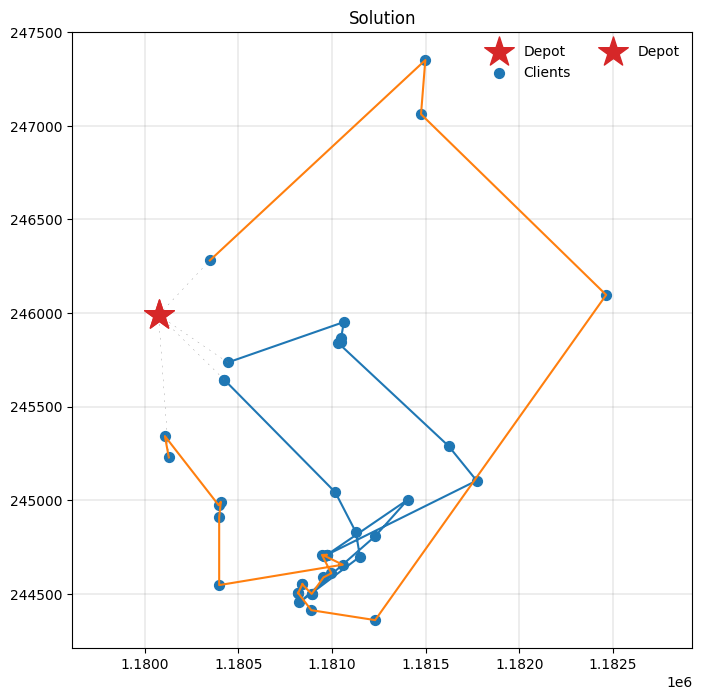

In [ ]:
print(res_100)
data_100 = m_100.data()
_, ax = plt.subplots(figsize=(8, 8))
plot_coordinates(data_100, ax=ax)
plot_solution(res_100.best, data_100, ax = ax)

## Trying some preprocesing strageties to reduce the workload
This intuition behind this step is to cluster a small number of places into one to reduce the work load of solver. In the following section I am going to trying a few huristices and evaluate the performance.

### 1. Intuitive, cluster three nearest places toegther.

In [ ]:
rand_agg_30.head()

,TRANSID,URGENTFLAG,VOLUME,WEIGHT,ROUTEID,LONGITUDE,LATITUDE,ADDRESS,SOURCEID
0,20,0.0,0.003725,27.0,8,118.104527,24.584472,盛光路566号,8296698
1,67,0.0,0.071552,288.6,7,118.093970,24.506962,湖里街道兴隆街道470.472.474号,8490300
2,103,0.0,0.006400,20.0,8,118.106309,24.595218,侨英街道霞梧120号,8384398
3,139,0.0,0.013750,100.0,4,118.176193,24.474191,前埔前村557号,8610734
4,324,0.0,0.002500,20.0,9,118.278790,24.666819,内厝镇内厝卫生院,8527949


In [ ]:
def format_data(rand_agg):
  data = []
  for i in range(rand_agg.shape[0]):
    cur = [rand_agg.iloc[i, 5], rand_agg.iloc[i, 5]]
    data.append(cur)
  return data

from sklearn.cluster import KMeans
import math
def custom_kmeans(rand_agg, n_clusters, max_items_per_cluster=3, max_iterations=100):
    X = format_data(rand_agg)
    clusters = [[] for _ in range(n_clusters)]
    kmeans = KMeans(n_clusters=n_clusters, max_iter=max_iterations, random_state=0)

    labels = kmeans.fit_predict(X)

    for i, label in enumerate(labels):
        if len(clusters[label]) < max_items_per_cluster:
            clusters[label].append(i)
        else:
            min_cluster = min(clusters, key=len)
            min_cluster.append(i)

    return clusters

def make_new_agg(rand_agg, clusters):
  column_vals = np.zeros(rand_agg.shape[0])
  for i, cluster in enumerate(clusters):
    for index in cluster:
      column_vals[index] = i

  rand_agg['cluster_id'] = column_vals

  new_agg = rand_agg.groupby(['cluster_id'], as_index=False).agg({'VOLUME': 'sum', 'WEIGHT': 'sum',
                                                                  'ROUTEID': 'first', 'LONGITUDE': 'mean',
                                                                  'LATITUDE': 'mean', 'ADDRESS': 'first',
                                                                  'SOURCEID': ', '.join, 'TRANSID': 'first',
                                                                  'URGENTFLAG':'max'})
  return new_agg
  #one_day_agg_full.columns = ['TRANSID', 'URGENTFLAG', 'VOLUME', 'WEIGHT', 'ROUTEID', 'SOURCEID', 'LATITUDE', 'LONGITUDE', 'ADDRESS']

In [ ]:
data = format_data(rand_agg_200)
n_clusters = math.ceil(rand_agg_200.shape[0]/3)
max_items_per_cluster = 3

result = custom_kmeans(rand_agg_200, n_clusters, max_items_per_cluster)
rand_agg_200_cluster = make_new_agg(rand_agg_200, result)

rand_agg_200_cluster = rand_agg_200_cluster[['TRANSID', 'URGENTFLAG', 'VOLUME', 'WEIGHT', 'ROUTEID', 'LONGITUDE',
       'LATITUDE', 'ADDRESS', 'SOURCEID', 'cluster_id']]
res = get_dist_time_mat(rand_agg_200_cluster, craw_df, traffic_df)
dist_mat_200_cluster = res[0]
time_mat_200_cluster = res[1]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
len(dist_mat_200_cluster)

23

### Run clustered location

In [ ]:
rand_agg_200_cluster.head()

,TRANSID,URGENTFLAG,VOLUME,WEIGHT,ROUTEID,LONGITUDE,LATITUDE,ADDRESS,SOURCEID,cluster_id
0,139,0.0,3.351501,592.00,4,118.149689,24.485099,前埔前村557号,"8225077, 8277371, 8656223, 8566253, 8632449, 8...",0.0
1,544,0.0,2.137235,523.52,2,118.097381,24.470930,湖滨南路201-209号,"8402773, 8582486, 8250968, 8295200",1.0
2,405,1.0,0.136196,216.12,11,118.057562,24.508948,杏西路14号,"8430118, 8678388, 8253157, 8590710",2.0
3,550,1.0,0.209020,284.00,2,118.143627,24.509137,湖滨南路201-209号,"8678833, 8223058, 8580278, 8366648, 8624108",3.0
4,893,1.0,33.448558,2915.10,10,118.132673,24.610043,中山路150号,"8522622, 8299099, 8591569, 8312080, 8381960, 8...",4.0


In [ ]:
m_200_cluster = Model()
for i in range(len(veh)):
    m_200_cluster.add_vehicle_type(capacity=veh.weight[i], num_available=1)
depot = m_200_cluster.add_depot(x = 1180073, y = 245989)
clients = [
    m_200_cluster.add_client(x = int(rand_agg_100.iloc[idx, 5]*10000),
                 y = int(rand_agg_200_cluster.iloc[idx, 6]*10000),
                 demand = int(rand_agg_200_cluster.iloc[idx, 3]/2)) #constrained by weight
    for idx in range(len(rand_agg_200_cluster))
]
locations = [depot, *clients]

for i in range(len(locations)):
    for j in range(len(locations)):
        distance = dist_mat_200_cluster[i, j]
        duration = time_mat_200_cluster[i, j]
        m_200_cluster.add_edge(locations[i], locations[j], distance=distance)

In [ ]:
res_200_cluster = m_200_cluster.solve(stop = NoImprovement(max_iterations = 10000))

#### Insepct Results

Solution results
    # routes: 7
   # clients: 22
   objective: 364122.00
# iterations: 10185
    run-time: 21.69 seconds

Routes
------
Route #1: 6 12 20 3 
Route #2: 11 
Route #3: 9 1 21 
Route #4: 13 7 10 8 14 2 4 
Route #5: 5 
Route #6: 15 18 
Route #7: 22 19 16 17 



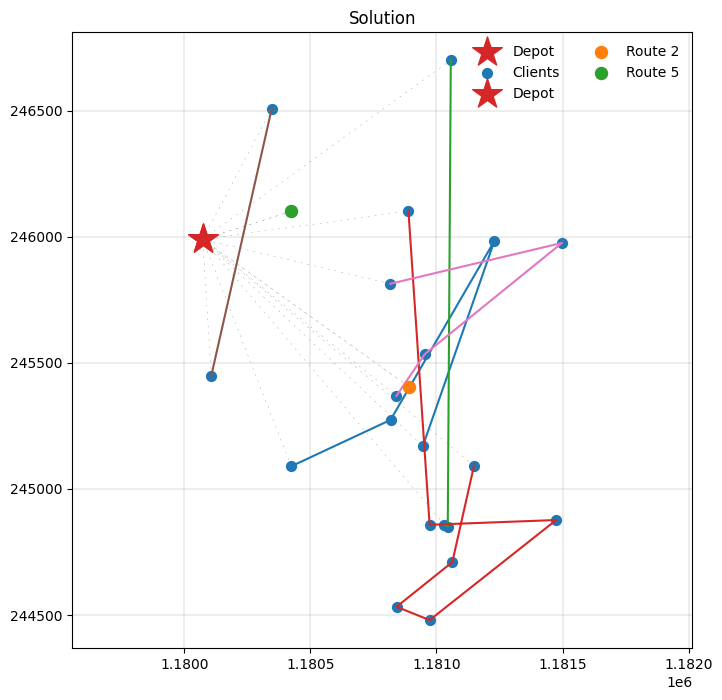

In [ ]:
print(res_200_cluster)
data_200_cluster = m_200_cluster.data()
_, ax = plt.subplots(figsize=(8, 8))
plot_coordinates(data_200_cluster, ax=ax)
plot_solution(res_200_cluster.best, data_200_cluster, ax = ax)